In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 106,336
training + validation N: 424,401


,set,input_ct,selected_ct,y,x
0,training,73.0,62.0,-1.021847,QYKLILNGKTLKGETTTEAHDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,122.0,0.0,-7.732188,QYKLILNGKTLKGETTTEAVDAATAEKVFPQYANDNGVDGEWTYDD...
2,training,794.0,598.0,-1.198072,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANKNGVDGEWTLDD...
3,training,1115.0,595.0,-1.694626,QYKLILNIKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDS...
4,validation,97.0,2.0,-5.819421,QYKLINNGKTLKGETTTEAVDAATAEKVFKIYANDNGVDGEWTYDD...


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])

In [4]:
from mavenn.src.layers.gpmap import CustomGPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(CustomGPMapLayer):
    """
    Represents a three stage thermodynamic model
    containing the states:
    1. Unfolded and unbound
    2. Folded and unbound
    3. Folded and bound.
    """

    def __init__(self, 
                 L,
                 C,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.L = L
        self.C= C
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        
        # define bias/chemical potential weight for folding energy
        self.mu_f = self.add_weight(name='mu_f',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)

        # define bias/chemical potential weight for binding energy
        self.mu_b = self.add_weight(name='mu_b',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)


        # Define theta_binding_lc parameters
        theta_b_lc_shape = (1, self.L, self.C)

        theta_b_lc_init = np.random.randn(*theta_b_lc_shape)/np.sqrt(self.L)
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                        shape=theta_b_lc_shape,
                                        initializer=Constant(theta_b_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # Define theta_folding_lc parameters
        theta_f_lc_shape = (1, self.L, self.C)

        theta_f_lc_init = np.random.randn(*theta_f_lc_shape)/np.sqrt(self.L)
        self.theta_f_lc = self.add_weight(name='theta_RNAP_lc',
                                        shape=theta_f_lc_shape,
                                        initializer=Constant(theta_f_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # reshape sequence to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # compute delta G for binding    
        G_b = self.mu_b + \
              tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for rnap
        G_f = self.mu_f + \
              tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                         shape=[-1, 1])            
        
        # compute p_fb
        p_fb = (K.exp(-G_f-G_b))/(1+K.exp(-G_f)+K.exp(-G_f-G_b))
        
        # return rate of transcription
        return p_fb


In [5]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'L':L,
                'C':20,
                'regularizer':0.05}

# Create model
model = mavenn.Model(L=L, 
                     alphabet='protein', 
                     regression_type='GE', 
                     gpmap_type='custom',
                     #ge_nonlinearity_type='linear',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2,
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer)

In [6]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.001,
          epochs=250,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=True)


N = 424,401 observations set as training data.
Using 24.9% for validation.
Data shuffled.
Time to set data: 13.7 sec.
Epoch 1/250
638/638 [==============================] - 7s 8ms/step - loss: 567.9799 - I_var: 0.8633 - val_loss: 22.6232 - val_I_var: 1.7393
Epoch 2/250
638/638 [==============================] - 3s 4ms/step - loss: 4.5802 - I_var: 1.8468 - val_loss: -43.2683 - val_I_var: 1.9331
Epoch 3/250
638/638 [==============================] - 3s 5ms/step - loss: -50.8636 - I_var: 1.9714 - val_loss: -68.1201 - val_I_var: 2.0065
Epoch 4/250
638/638 [==============================] - 4s 6ms/step - loss: -68.4606 - I_var: 2.0135 - val_loss: -45.8875 - val_I_var: 1.9438
Epoch 5/250
638/638 [==============================] - 3s 5ms/step - loss: -76.0797 - I_var: 2.0326 - val_loss: -72.0405 - val_I_var: 2.0205
Epoch 6/250
638/638 [==============================] - 3s 5ms/step - loss: -79.9871 - I_var: 2.0445 - val_loss: -77.5623 - val_I_var: 2.0377
Epoch 7/250
638/638 [==================

Epoch 57/250
638/638 [==============================] - 3s 4ms/step - loss: -115.3589 - I_var: 2.1733 - val_loss: -114.7344 - val_I_var: 2.1747
Epoch 58/250
638/638 [==============================] - 3s 4ms/step - loss: -115.2738 - I_var: 2.1737 - val_loss: -113.5490 - val_I_var: 2.1710
Epoch 59/250
638/638 [==============================] - 3s 4ms/step - loss: -113.4955 - I_var: 2.1727 - val_loss: -114.7444 - val_I_var: 2.1742
Epoch 60/250
638/638 [==============================] - 3s 4ms/step - loss: -112.7801 - I_var: 2.1695 - val_loss: -108.2041 - val_I_var: 2.1552
Epoch 61/250
638/638 [==============================] - 3s 4ms/step - loss: -114.3928 - I_var: 2.1735 - val_loss: -114.2636 - val_I_var: 2.1726
Epoch 62/250
638/638 [==============================] - 3s 4ms/step - loss: -115.9480 - I_var: 2.1733 - val_loss: -115.2203 - val_I_var: 2.1750
Epoch 63/250
638/638 [==============================] - 3s 4ms/step - loss: -116.5319 - I_var: 2.1737 - val_loss: -103.4702 - val_I_var:

Epoch 114/250
638/638 [==============================] - 3s 4ms/step - loss: -118.8457 - I_var: 2.1750 - val_loss: -116.0613 - val_I_var: 2.1685
Epoch 115/250
638/638 [==============================] - 3s 4ms/step - loss: -119.7871 - I_var: 2.1773 - val_loss: -119.1295 - val_I_var: 2.1773
Epoch 116/250
638/638 [==============================] - 3s 4ms/step - loss: -117.6219 - I_var: 2.1752 - val_loss: -116.1260 - val_I_var: 2.1685
Epoch 117/250
638/638 [==============================] - 3s 5ms/step - loss: -120.0087 - I_var: 2.1747 - val_loss: -116.4578 - val_I_var: 2.1693
Epoch 118/250
638/638 [==============================] - 4s 5ms/step - loss: -116.6645 - I_var: 2.1768 - val_loss: -119.5179 - val_I_var: 2.1780
Epoch 119/250
638/638 [==============================] - 3s 5ms/step - loss: -119.8442 - I_var: 2.1764 - val_loss: -114.0047 - val_I_var: 2.1618
Epoch 120/250
638/638 [==============================] - 3s 4ms/step - loss: -117.8904 - I_var: 2.1760 - val_loss: -113.8958 - val

638/638 [==============================] - 3s 5ms/step - loss: -123.4544 - I_var: 2.1783 - val_loss: -118.9362 - val_I_var: 2.1695
Epoch 171/250
638/638 [==============================] - 4s 6ms/step - loss: -122.7672 - I_var: 2.1773 - val_loss: -116.9787 - val_I_var: 2.1637
Epoch 172/250
638/638 [==============================] - 3s 5ms/step - loss: -123.4091 - I_var: 2.1788 - val_loss: -120.8748 - val_I_var: 2.1748
Epoch 173/250
638/638 [==============================] - 4s 5ms/step - loss: -120.2842 - I_var: 2.1761 - val_loss: -122.4077 - val_I_var: 2.1790
Epoch 174/250
638/638 [==============================] - 3s 5ms/step - loss: -122.5631 - I_var: 2.1787 - val_loss: -117.7295 - val_I_var: 2.1656
Epoch 175/250
638/638 [==============================] - 3s 5ms/step - loss: -122.0882 - I_var: 2.1778 - val_loss: -121.7757 - val_I_var: 2.1770
Epoch 176/250
638/638 [==============================] - 3s 5ms/step - loss: -121.7300 - I_var: 2.1788 - val_loss: -116.3028 - val_I_var: 2.1611

638/638 [==============================] - 3s 5ms/step - loss: -125.5274 - I_var: 2.1776 - val_loss: -124.8588 - val_I_var: 2.1808
Epoch 227/250
638/638 [==============================] - 3s 5ms/step - loss: -124.6324 - I_var: 2.1810 - val_loss: -122.8336 - val_I_var: 2.1747
Epoch 228/250
638/638 [==============================] - 3s 5ms/step - loss: -123.7554 - I_var: 2.1806 - val_loss: -113.9100 - val_I_var: 2.1489
Epoch 229/250
638/638 [==============================] - 3s 5ms/step - loss: -122.7218 - I_var: 2.1788 - val_loss: -125.1968 - val_I_var: 2.1814
Epoch 230/250
638/638 [==============================] - 3s 5ms/step - loss: -124.2234 - I_var: 2.1789 - val_loss: -117.6213 - val_I_var: 2.1594
Epoch 231/250
638/638 [==============================] - 3s 5ms/step - loss: -123.9676 - I_var: 2.1809 - val_loss: -124.7251 - val_I_var: 2.1799
Epoch 232/250
638/638 [==============================] - 3s 5ms/step - loss: -124.1100 - I_var: 2.1803 - val_loss: -122.8745 - val_I_var: 2.1745

On test data:
I_var_test: 2.167 +- 0.010 bits
I_pred_test: 2.213 +- 0.004 bits


Text(0.5, 1.0, 'training hisotry')

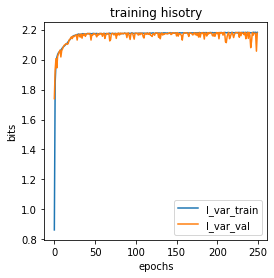

In [7]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df['y'].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
#ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
#ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

In [8]:
#model.save('gb1_threestate_thermodynamic_models/gb1_three_state_1')

In [23]:
#model = mavenn.load('gb1_threestate_thermodynamic_models/gb1_three_state_1')

Model loaded from these files:
	gb1_threestate_thermodynamic_models/gb1_three_state_1.pickle
	gb1_threestate_thermodynamic_models/gb1_three_state_1.h5


In [10]:
# 1.852 Gaussian
# 2.015 skewedT 

In [24]:
# Subsample indices for easy plotting and information estimation
N_test = len(test_df)
ix = np.random.rand(N_test) < .2

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

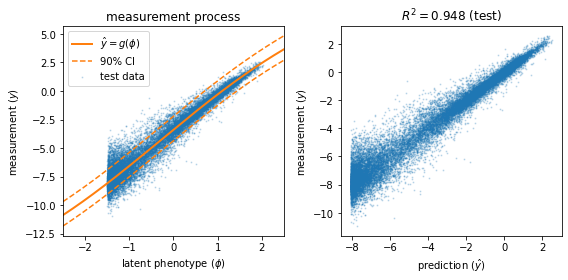

In [25]:
# Compute phi and yhat values
phi = model.x_to_phi(x_test)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-2.5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
#yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.05,.95])

# Create two panels
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

# Illustrate measurement process with GE curve
ax[0].scatter(phi, y_test, color='C0', s=1, alpha=.2, label='test data')
ax[0].plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax[0].plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='90% CI')
ax[0].plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax[0].set_xlim(phi_lim)
ax[0].set_xlabel('latent phenotype ($\phi$)')
ax[0].set_ylabel('measurement ($y$)')
ax[0].set_title('measurement process')
ax[0].legend()

Rsq = np.corrcoef(yhat,y_test)[0][1]**2
ax[1].scatter(yhat, y_test, color='C0', s=1, alpha=.2, label='test data')
ax[1].set_xlabel('prediction ($\hat{y}$)')
ax[1].set_ylabel('measurement ($y$)')
ax[1].set_title(f'$R^2 = ${Rsq:.3f} (test)')

# Fix up plot
fig.tight_layout()
plt.show()

In [26]:
theta_binding_lc = model.get_nn().layers[2].get_weights()[2][0]
theta_folding_lc = model.get_nn().layers[2].get_weights()[3][0]
theta_0_f = model.get_nn().layers[2].get_weights()[0][0]
theta_0_b = model.get_nn().layers[2].get_weights()[1][0]

In [27]:
from mavenn.src.utils import _x_to_mat

# Code taken from mavenn model.get_theta
def fix_theta_wt_gauge(theta_lc,
                       theta_0,
                       L,
                       C,
                       consensus_seq,
                       alphabet):

    p_lc = _x_to_mat(consensus_seq, alphabet)

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]    
        
    return fixed_theta_0, fixed_theta_lc


In [28]:
# fix_theta_wt_gauge(theta_binding_lc, 
#                    theta_0_b)
gb1_seq = model.x_stats['consensus_seq']

theta_0_b_gf, theta_binding_lc_gf = fix_theta_wt_gauge(theta_binding_lc, 
                                                       theta_0_b,
                                                       L,
                                                       model.C,
                                                       gb1_seq,
                                                       model.alphabet)

theta_0_f_gf, theta_folding_lc_gf = fix_theta_wt_gauge(theta_folding_lc, 
                                                       theta_0_f,
                                                       L,
                                                       model.C,
                                                       gb1_seq,
                                                       model.alphabet)

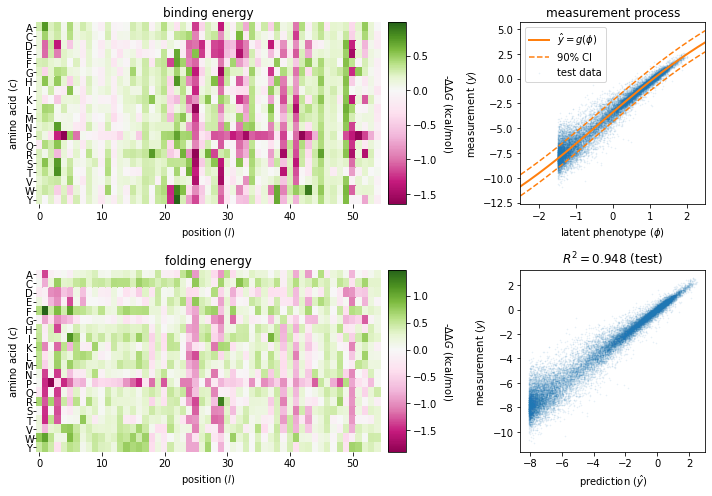

In [30]:
# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
# theta_dict = model.get_theta(gauge='user',
#                              x_wt=gb1_seq)

# Create two panels
fig, axs = plt.subplots(2, 2, figsize=[10, 7], gridspec_kw={'width_ratios':[1,0.5]})

# Left panel: draw heatmap illustrating 1pt mutation effects
ax = axs[0,0]
ax, cb = mavenn.heatmap(-0.62*theta_binding_lc,
                        alphabet=model.alphabet,
                        #seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('-$\Delta\Delta G$ (kcal/mol)', rotation=-90, va="bottom")
ax.set_title('binding energy')

ax = axs[0,1]
ax.scatter(phi, y_test, color='C0', s=0.5, alpha=.08, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='90% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

ax = axs[1,0]
# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb1 = mavenn.heatmap(-0.62*theta_folding_lc,
                        alphabet=model.alphabet,
                        #seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb1.set_label('-$\Delta\Delta G$ (kcal/mol)', rotation=-90, va="bottom")
ax.set_title('folding energy')

ax = axs[1,1]
Rsq = np.corrcoef(yhat,y_test)[0][1]**2
ax.scatter(yhat, y_test, color='C0', s=0.5, alpha=.08, label='test data')
ax.set_xlabel('prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'$R^2 = ${Rsq:.3f} (test)')


# Fix up plot
fig.tight_layout()
#fig.savefig('binding_folding_theta_gf.png',bbox_inches='tight',dpi=200)
plt.show()

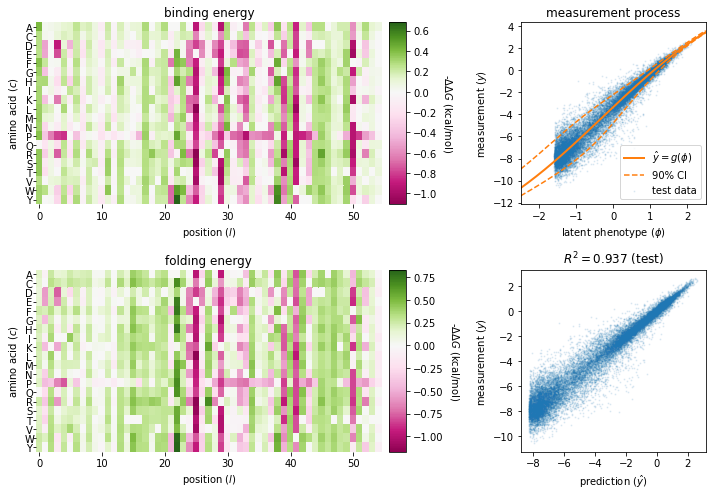

In [17]:
# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
# theta_dict = model.get_theta(gauge='user',
#                              x_wt=gb1_seq)

# Create two panels
fig, axs = plt.subplots(2, 2, figsize=[10, 7], gridspec_kw={'width_ratios':[1,0.5]})

# Left panel: draw heatmap illustrating 1pt mutation effects
ax = axs[0,0]
ax, cb = mavenn.heatmap(-0.62*theta_binding_lc_gf,
                        alphabet=model.alphabet,
                        #seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('-$\Delta\Delta G$ (kcal/mol)', rotation=-90, va="bottom")
ax.set_title('binding energy')

ax = axs[0,1]
ax.scatter(phi, y_test, color='C0', s=1, alpha=.1, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='90% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

ax = axs[1,0]
# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb1 = mavenn.heatmap(-0.62*theta_folding_lc_gf,
                        alphabet=model.alphabet,
                        #seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb1.set_label('-$\Delta\Delta G$ (kcal/mol)', rotation=-90, va="bottom")
ax.set_title('folding energy')

ax = axs[1,1]
Rsq = np.corrcoef(yhat,y_test)[0][1]**2
ax.scatter(yhat, y_test, color='C0', s=1, alpha=.1, label='test data')
ax.set_xlabel('prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'$R^2 = ${Rsq:.3f} (test)')


# Fix up plot
fig.tight_layout()
#fig.savefig('binding_folding_theta_gf.png',bbox_inches='tight',dpi=200)
plt.show()

In [31]:
gb1_seq

'QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'

In [19]:
# theta_binding_df = pd.DataFrame(theta_binding_lc_gf,columns=model.alphabet)
# theta_folding_df = pd.DataFrame(theta_folding_lc_gf,columns=model.alphabet)
# jakub_columns_order = ['K','R','H','E','D','N','Q','T','S','C','G','A','V','L','I','M','P','Y','F','W']

In [20]:
# import seaborn as sns

# fig, ax = plt.subplots(2, 1, figsize=[12, 10])

# ax[0] = sns.heatmap(theta_binding_df[jakub_columns_order].T, ax=ax[0], cmap='PiYG')
# ax[1] = sns.heatmap(theta_folding_df[jakub_columns_order].T, ax=ax[1], cmap='PiYG')

In [34]:
temp = mavenn.load_example_model('gb1_ge_additive')

Model loaded from these files:
	/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn/examples/models/gb1_ge_additive.pickle
	/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn/examples/models/gb1_ge_additive.h5


In [35]:
temp.x_stats['consensus_seq']

'QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'